<a href="https://colab.research.google.com/github/vedikar/LibriSpeech-ASR-Corpus/blob/main/LibriSpeech_ASR_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d victorling/librispeech-clean --unzip -p /content/librispeech-clean


Dataset URL: https://www.kaggle.com/datasets/victorling/librispeech-clean
License(s): Attribution 4.0 International (CC BY 4.0)
100% 28.0G/28.1G [05:56<00:00, 114MB/s]
100% 28.1G/28.1G [05:56<00:00, 84.5MB/s]


In [ ]:
!ls /content/librispeech-clean

LibriSpeech


In [ ]:
!ls -R /content/librispeech-clean

Streaming output truncated to the last 5000 lines.
7832-258250-0011.flac  7832-258250-0026.flac  7832-258250-0041.flac  7832-258250.trans.txt
7832-258250-0012.flac  7832-258250-0027.flac  7832-258250-0042.flac
7832-258250-0013.flac  7832-258250-0028.flac  7832-258250-0043.flac
7832-258250-0014.flac  7832-258250-0029.flac  7832-258250-0044.flac

/content/librispeech-clean/LibriSpeech/train-clean-360/7833:
102238	102239

/content/librispeech-clean/LibriSpeech/train-clean-360/7833/102238:
7833-102238-0000.flac  7833-102238-0015.flac  7833-102238-0030.flac  7833-102238-0045.flac
7833-102238-0001.flac  7833-102238-0016.flac  7833-102238-0031.flac  7833-102238-0046.flac
7833-102238-0002.flac  7833-102238-0017.flac  7833-102238-0032.flac  7833-102238-0047.flac
7833-102238-0003.flac  7833-102238-0018.flac  7833-102238-0033.flac  7833-102238-0048.flac
7833-102238-0004.flac  7833-102238-0019.flac  7833-102238-0034.flac  7833-102238-0049.flac
7833-102238-0005.flac  7833-102238-0020.flac  7833-102

In [ ]:
!pip install torchaudio
!pip install torch


In [ ]:
import os

root_path = '/content/librispeech-clean/LibriSpeech'
print(os.listdir(root_path))  # Lists available subsets (e.g., 'train-clean-100', 'test-clean')


['train-clean-100', 'README.TXT', 'LICENSE.TXT', 'train-clean-360', 'SPEAKERS.TXT', 'BOOKS.TXT', 'test-clean', 'dev-clean', 'CHAPTERS.TXT']


In [ ]:
# Define pipeline parameters
pipeline_params = {
    "batch_size": 5,
    "epochs": 10,
    "learning_rate": 1e-4,
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
}

import torchaudio
import torch
import random
from torch.utils.data import DataLoader, Subset, random_split

# Define the root path where the dataset is stored
root_path = '/content/librispeech-clean'

# Load the entire train-clean-100 dataset
full_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)

# Randomly sample indices to create a smaller subset
subset_size = 6500  # Adjust this as needed
indices = random.sample(range(len(full_dataset)), subset_size)
subset_dataset = Subset(full_dataset, indices)

# Define sizes for training, validation, and test splits
train_size = int(0.8 * len(subset_dataset))  # 80% for training
val_size = int(0.1 * len(subset_dataset))    # 10% for validation
test_size = len(subset_dataset) - train_size - val_size  # Remaining 10% for testing

# Randomly split the subset dataset
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

# Define DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=pipeline_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=pipeline_params["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=pipeline_params["batch_size"], shuffle=False)

# Inspect a sample from the train dataset
waveform, sample_rate, utterance, _, _, _ = train_dataset[0]
print(f"Sample Text: {utterance}")
print(f"Waveform Shape: {waveform.shape}")
print(f"Sample Rate: {sample_rate}")


Sample Text: BUT HALF RECOVERED FROM HIS WONDER HE WAS JUST RAISING HIS VOICE TO UTTER A REMONSTRANCE WHEN TO HIS SEVENFOLD AMAZEMENT THE DOOR WAS OPENED TO THE KNOCK AND THE OLD MAN DISAPPEARED WITHIN
Waveform Shape: torch.Size([1, 249360])
Sample Rate: 16000


In [ ]:
def normalize_waveform(waveform):
    mean = waveform.mean()
    std = waveform.std()
    return (waveform - mean) / std

# Example usage

normalized_waveform = normalize_waveform(waveform)

#verify normalization
normalized_mean = normalized_waveform.mean()
normalized_std = normalized_waveform.std()
print(f"Normalized Mean: {normalized_mean}")
print(f"Normalized Std: {normalized_std}")


Normalized Mean: 1.896945933665961e-09
Normalized Std: 0.9999999403953552


In [ ]:
waveform_resampled = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
print(f"Resampled Waveform Shape: {waveform_resampled.shape}")


Resampled Waveform Shape: torch.Size([1, 249360])


In [ ]:
spectrogram = torchaudio.transforms.Spectrogram()(waveform)
mfcc = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13)(waveform)
log_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)(waveform)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


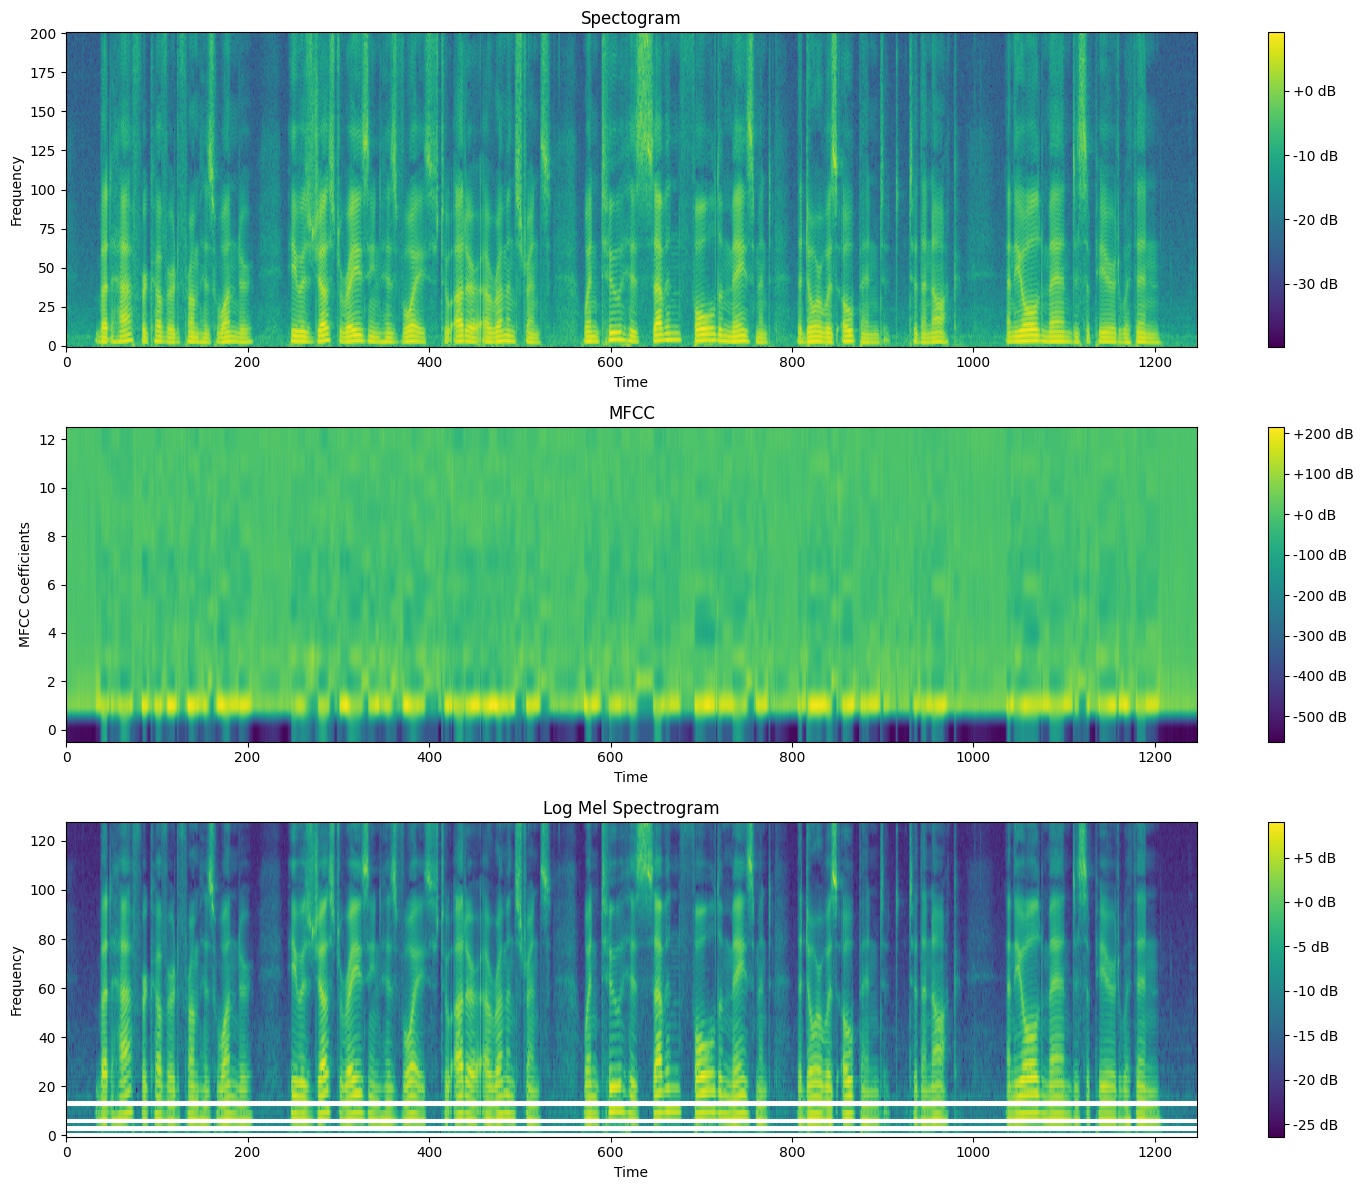

In [ ]:
import matplotlib.pyplot as plt
import torchaudio

plt.figure(figsize = (15, 12))

plt.subplot(3, 1, 1)
plt.imshow(spectrogram.log2()[0, :, :].numpy(), aspect = 'auto' , origin = 'lower')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.subplot(3 , 1 , 2)
plt.imshow(mfcc[0,:,:].detach().numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")

plt.subplot(3 , 1 , 3)
plt.imshow(log_mel_spectrogram.log2()[0, :, :].numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title("Log Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def levenshtein_distance(ref, hyp):
    """Calculates the Levenshtein distance between two sequences."""
    m, n = len(ref), len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    """Normalizes text based on the specified conditions."""
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    """Calculates edit distance and length/reference length based on the mode (word or char level)."""
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculates word error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculates character error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    return edit_distance / ref_len


In [ ]:
cer("olyaa", "olya")

0.2

In [ ]:
# Example reference and hypothesis texts
reference = "this is the reference text"
hypothesis = "this is the text"

# Calculate WER
word_error_rate = wer(reference, hypothesis)
print(f"Word Error Rate (WER): {word_error_rate:.2f}")

# Calculate CER
char_error_rate = cer(reference, hypothesis)
print(f"Character Error Rate (CER): {char_error_rate:.2f}")


Word Error Rate (WER): 0.20
Character Error Rate (CER): 0.35


In [ ]:
import torch
import torchaudio

# Load the pre-trained Wav2Vec2 model and the corresponding labels
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
asr_model = bundle.get_model()

# Set the model to evaluation mode
asr_model.eval()

# Load the label map (which maps tokens to characters)
labels = bundle.get_labels()


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:02<00:00, 152MB/s]


In [ ]:
def greedy_decode(emissions, labels):
    """Decodes the emissions using a greedy algorithm."""
    tokens = torch.argmax(emissions, dim=-1)
    transcription = ''.join([labels[token] for token in tokens])
    return transcription.replace('|', ' ').strip()

def transcribe_waveform(waveform, sample_rate):
    # Resample if the sample rate is not 16000 Hz (Wav2Vec2 expects 16kHz)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

    # Ensure waveform is 2D (batch_size, time)
    waveform = waveform.squeeze(0)  # Removes the channel dimension if present

    with torch.no_grad():
        # Add a batch dimension to the waveform
        waveform = waveform.unsqueeze(0)
        emissions, _ = asr_model(waveform)

        # Decode the emissions to get the transcription
        transcription = greedy_decode(emissions[0], labels)

    return transcription


In [ ]:
# Example usage with the LibriSpeech dataset
for i in range(len(test_dataset)):
    waveform, sample_rate, reference, _, _, _ = test_dataset[i]
    hypothesis = transcribe_waveform(waveform, sample_rate)  # Transcribe the audio

    word_error_rate = wer(reference, hypothesis)
    char_error_rate = cer(reference, hypothesis)

    print(f"Sample {i}:")
    print(f" Reference: {reference}")
    print(f" Hypothesis: {hypothesis}")
    print(f" WER: {word_error_rate:.2f}")
    print(f" CER: {char_error_rate:.2f}")
    print()


Sample 0:
 Reference: ITS VISCERAL PERTURBATIONS ARE MY EMOTIONS THE OBSTINATE CONTROVERSIES THAT HAVE ARISEN OVER SUCH STATEMENTS AS THESE WHICH SOUND SO PARADOXICAL AND WHICH CAN YET BE MADE SO SERIOUSLY
 Hypothesis: ------------------------------IITTSS -V---I--C---E-RR--ALL-   -P---ER--T---UR-B---A---T-I--ON----S  ---------------------------------ARRE   M---Y--  E--MM---O--T-I--ON---SS  --------------------------------------------------------------------------------------------------------------------------------------------TH-E-  -----O-B-SSTT-I-NNA-TEE  ---C---ON--TRR-O-V--ERR---S---IEES  T-HAT- HAV-E  A--RR--I--S--ENN    ------OO-V--ERR   --S---U-CHH  -SST---A--TEE-M-EN-TTSS  --A-S-   -THH--EE-SEE-   -------------------------------------WWH-IC-H   -S----OUUNNDD-  SS-OO--  -P--A-RRR-A--D---OOXX------ICC--A-L--   ---------------------------AND-  -WHH-ICHH  --C---AN--  -Y--E--T-  -B-EE  -M---A-DDEE  --S---OO--  -SS---E-RR-I--OU-SS--LL--Y   ------------------
 WER: 2.31
 CER: 3.14

S

In [ ]:
import string

def normalize_text(text, ignore_case=True, remove_punctuation=True, remove_space=True, delimiter=None):
    """
    Normalize the given text by performing case conversion, punctuation removal,
    space removal, and optional tokenization based on the delimiter.

    Args:
        text (str or list): Input text to normalize (can be a single string or a list of strings).
        ignore_case (bool): Whether to convert the text to lowercase. Default is True.
        remove_punctuation (bool): Whether to remove punctuation. Default is True.
        remove_space (bool): Whether to remove extra spaces. Default is True.
        delimiter (str or None): Split text based on this delimiter (None for no split).
                                 Use '' for character-level tokenization (special case).

    Returns:
        str or list: Normalized text (or list if split by delimiter or input is a list).
    """

    # Check if the input is None or empty
    if not text:
        return "" if delimiter is None else []

    # If input is a list, normalize each element in the list
    if isinstance(text, list):
        return [normalize_text(t, ignore_case, remove_punctuation, remove_space, delimiter) for t in text]

    # Normalize a single string
    # Convert to lowercase if required
    if ignore_case:
        text = text.lower()

    # Remove punctuation if required
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra spaces if required
    if remove_space:
        text = ' '.join(text.split())

    # Handle character-level tokenization
    if delimiter == '':
        return list(text)  # Tokenize into individual characters

    # Tokenize the text based on the delimiter (e.g., space for words or another character)
    if delimiter is not None:
        text = text.split(delimiter)

    return text

# Example usage with LibriSpeech ASR transcriptions:
reference_text = "This is a simple sentence, with punctuation!"
hypothesis_text = "this   is a simple sentence without punctuation"
multiple_texts = ["Sentence one.", "This is sentence two!"]

# Normalizing single strings
normalized_ref = normalize_text(reference_text, ignore_case=True, remove_punctuation=True, remove_space=True)
normalized_hyp = normalize_text(hypothesis_text, ignore_case=True, remove_punctuation=True, remove_space=True)

print(f"Normalized Reference: {normalized_ref}")
print(f"Normalized Hypothesis: {normalized_hyp}")

# Normalizing a list of texts
normalized_multiple = normalize_text(multiple_texts, ignore_case=True, remove_punctuation=True, remove_space=True)
print(f"Normalized Multiple Texts: {normalized_multiple}")

# Example with character-level tokenization:
normalized_ref_char = normalize_text(reference_text, ignore_case=True, remove_punctuation=True, remove_space=True, delimiter='')
normalized_hyp_char = normalize_text(hypothesis_text, ignore_case=True, remove_punctuation=True, remove_space=True, delimiter='')

print(f"Character-Level Normalized Reference: {normalized_ref_char}")
print(f"Character-Level Normalized Hypothesis: {normalized_hyp_char}")

# Example with word-level tokenization:
normalized_ref_word = normalize_text(reference_text, ignore_case=True, remove_punctuation=True, remove_space=True, delimiter=' ')
normalized_hyp_word = normalize_text(hypothesis_text, ignore_case=True, remove_punctuation=True, remove_space=True, delimiter=' ')

print(f"Word-Level Normalized Reference: {normalized_ref_word}")
print(f"Word-Level Normalized Hypothesis: {normalized_hyp_word}")



Normalized Reference: this is a simple sentence with punctuation
Normalized Hypothesis: this is a simple sentence without punctuation
Normalized Multiple Texts: ['sentence one', 'this is sentence two']
Character-Level Normalized Reference: ['t', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 's', 'i', 'm', 'p', 'l', 'e', ' ', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', ' ', 'w', 'i', 't', 'h', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']
Character-Level Normalized Hypothesis: ['t', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 's', 'i', 'm', 'p', 'l', 'e', ' ', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', ' ', 'w', 'i', 't', 'h', 'o', 'u', 't', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']
Word-Level Normalized Reference: ['this', 'is', 'a', 'simple', 'sentence', 'with', 'punctuation']
Word-Level Normalized Hypothesis: ['this', 'is', 'a', 'simple', 'sentence', 'without', 'punctuation']


In [ ]:
import string
from itertools import dropwhile

class TextTransform:
    """Maps characters to integers and vice versa, using the string module for character definitions."""
    def __init__(self):
        # Including additional characters manually and using string.ascii_lowercase for letters
        additional_chars = ["'", "<SPACE>"]
        all_chars = additional_chars + list(string.ascii_lowercase)

        # Generating char_map with enumeration, starting indices from 0
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' '  # Ensuring space is correctly mapped

    def text_to_int(self, text):
        """Converts text to an integer sequence using a character map."""
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]

    def int_to_text(self, labels):
        """Converts integer labels to a text sequence using a character map."""
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')

    def int_to_text_remove_pad(self, int_sequence):
        # Remove trailing zeros which are used for padding
        # This is done by reversing the list, using itertools.dropwhile to drop the zeros,
        # and then reversing the list back to the original order
        from itertools import dropwhile

        # Reverse, remove zeros from the end (now start), and reverse back
        text_sequence = list(dropwhile(lambda x: x == 0, reversed(int_sequence)))[::-1]

        # Convert the non-padded sequence to text
        text = ''.join(self.index_map[i] for i in text_sequence).replace('<SPACE>', ' ')
        return text

# Instantiating the TextTransform class
text_transform = TextTransform()

# Example usage
test_text = "Hello world"
test_ints = text_transform.text_to_int(test_text)
recovered_text = text_transform.int_to_text(test_ints)

# Output the results
print(f"Original: {test_text}")
print(f"Converted to ints: {test_ints}")
print(f"Recovered text: {recovered_text}")



Original: Hello world
Converted to ints: [9, 6, 13, 13, 16, 1, 24, 16, 19, 13, 5]
Recovered text: hello world


In [ ]:
test_int = [0, 4, 2, 4, 27, 27, 27, 0, 0]
# print(test_int)
print("start: " + text_transform.int_to_text_remove_pad(test_int) + "|end")

start: 'caczzz|end


In [ ]:
import torch
import torch.nn as nn

text_transform = TextTransform()

texts = ["Hello world", "My name is Oles"]
labels = [torch.Tensor(text_transform.text_to_int(text)) for text in texts]
labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
labels

tensor([[ 9.,  6., 13., 13., 16.,  1., 24., 16., 19., 13.,  5.,  0.,  0.,  0.,
          0.],
        [14., 26.,  1., 15.,  2., 14.,  6.,  1., 10., 20.,  1., 16., 13.,  6.,
         20.]])

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
spec.shape

torch.Size([1247, 128])

In [ ]:
spectrograms = []
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in [train_dataset[0], train_dataset[1]]:
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms.append(spec)
spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
spectrograms.size()

torch.Size([2, 1, 128, 1247])

In [ ]:
import torch
import torch.nn as nn

def data_processing(data, data_type="train"):
    if data_type not in ["train", "valid"]:
        raise ValueError('data_type should be either "train" or "valid".')

    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms

    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [ ]:
import torch.utils.data as data

pipeline_params = {
    "batch_size": 5,
    "epochs": 10,
    "learning_rate": 1e-4,
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride":2,
    "dropout": 0.1,
}

kwargs = {"num_workers": 1, "pin_memory": True}
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=pipeline_params["batch_size"],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=pipeline_params["batch_size"],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

print("Picked device:", device)

class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    """
    Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3 // 2)  # CNN for extracting hierarchical features

        # n residual CNN layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats * 32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i == 0 else rnn_dim * 2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i == 0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim * 2, rnn_dim),  # BiRNN returns rnn_dim * 2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

model = SpeechRecognitionModel(
    pipeline_params['n_cnn_layers'],
    pipeline_params['n_rnn_layers'],
    pipeline_params['rnn_dim'],
    pipeline_params['n_class'],
    pipeline_params['n_feats'],
    pipeline_params['stride'],
    pipeline_params['dropout']
).to(device)


True
Picked device: cuda


In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and set as:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Running on CPU")


GPU is available and set as: Tesla T4


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.AdamW(model.parameters(), pipeline_params["learning_rate"])

criterion = nn.CTCLoss(blank=28).to(device)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=pipeline_params["learning_rate"],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=pipeline_params["epochs"],
                                        anneal_strategy="linear")

data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100
for epoch in range(pipeline_params["epochs"]):
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if logging_idx % logging_freq == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch,
                batch_idx * len(spectrograms),
                data_len, 100. * batch_idx / len(train_loader),
                loss.item()
            ))
        logging_idx += 1

Train Epoch: 0 [0/5200 (0%)]	Loss: 7.209424
Train Epoch: 0 [500/5200 (10%)]	Loss: 3.429835
Train Epoch: 0 [1000/5200 (19%)]	Loss: 2.917626
Train Epoch: 0 [1500/5200 (29%)]	Loss: 2.884535
Train Epoch: 0 [2000/5200 (38%)]	Loss: 2.857673
Train Epoch: 0 [2500/5200 (48%)]	Loss: 2.874256
Train Epoch: 0 [3000/5200 (58%)]	Loss: 2.870955
Train Epoch: 0 [3500/5200 (67%)]	Loss: 2.931990
Train Epoch: 0 [4000/5200 (77%)]	Loss: 2.877420
Train Epoch: 0 [4500/5200 (87%)]	Loss: 2.926668
Train Epoch: 0 [5000/5200 (96%)]	Loss: 2.868874
Train Epoch: 1 [300/5200 (6%)]	Loss: 2.802078
Train Epoch: 1 [800/5200 (15%)]	Loss: 2.841347
Train Epoch: 1 [1300/5200 (25%)]	Loss: 2.963692
Train Epoch: 1 [1800/5200 (35%)]	Loss: 2.926410
Train Epoch: 1 [2300/5200 (44%)]	Loss: 2.903258
Train Epoch: 1 [2800/5200 (54%)]	Loss: 2.901383
Train Epoch: 1 [3300/5200 (63%)]	Loss: 2.875275
Train Epoch: 1 [3800/5200 (73%)]	Loss: 2.850250
Train Epoch: 1 [4300/5200 (83%)]	Loss: 2.829326
Train Epoch: 1 [4800/5200 (92%)]	Loss: 2.799633
